# Converting annotations to semantic segmentation mask images


**Overview:**

![annotations_to_masks](https://user-images.githubusercontent.com/22067552/80074017-9394d200-8516-11ea-9c54-870cf8646977.png)

The DSA database stores annotations in an (x,y) coordinate list format. For many tasks that process annotation data like training machine learning algorithms or measuring interobserver agreement a mask image representation where pixel values encode ground truth information is more useful.

This notebook demonstrates tools to convert annotations into semantic segmentation mask images. There are two approaches for generating these images:

* Generate a mask image from a region defined by user-specified coordinates.

* Generate mask images from annotations contained within _region-of-interest_ (ROI) annotations. This involves mapping annotations to these ROIs and creating one image per ROI.

The examples below extend approaches described in Amgad et al, 2019:

*Mohamed Amgad, Habiba Elfandy, Hagar Hussein, ..., Jonathan Beezley, Deepak R Chittajallu, David Manthey, David A Gutman, Lee A D Cooper, Structured crowdsourcing enables convolutional segmentation of histology images, Bioinformatics, , btz083, https://doi.org/10.1093/bioinformatics/btz083*

A csv file like the one in
``histomicstk/annotations_and_masks/tests/test_files/sample_GTcodes.csv`` is needed to define what group each pixel value corresponds to in the mask image, to define the overlay order of various annotation groups, and to define which groups represent ROIs. Note that the term "group" here comes from the annotation model where each group represents a class like "tumor" or "necrosis" and is associated with an annotation style.

The code demonstrated in this notebook extends functionality of the current API endpoints that get annotations as a list of dictionaries, including handing the following complex situations:

* Getting RGB and mask images at the same magnification/resolution

* User-defined regions to query, including cropping of annotations to defined region

* Retrieving annotations from ROIs, including rotated rectangles and polygons

* Overlapping annotations

* "Background" class (eg. anything not-otherwise-specified is stroma)

* Getting contours (coordinate lists in ROI frame) and bounding boxes relative to images at the same resolution, to be used to trainign object localization models like Faster-RCNN.


**There are four run modes:**

* **wsi**: get scaled up/down version of mask of whole slide

* **min_bounding_box**: get minimum box for all annotations in slide

* **manual_bounds**: use given xy coordinate bounds provided by the 'bounds' param

* **polygonal_bounds**: use manually-drawn polygonal (or rectanglar) ROI boundaries

**Here is a sample result:**

**Source annotations**

![before](https://user-images.githubusercontent.com/22067552/63966887-46855c80-ca6a-11e9-8431-932fda6cffc1.png)

**Corresponding masks**

If the ``polygonal_bounds`` mode is used though its wrapper function (see jupyter),
the result is saved mask files named something like:
`TCGA-A2-A0YE_left-59201_top-33493_bottom-63742_right-38093.png`


**Where to look?**

```
|_ histomicstk/
  |_annotations_and_masks/
  |  |_annotation_and_mask_utils.py
  |  |_annotations_to_masks_handler.py
  |_tests/
      |_ test_annotation_and_mask_utils.py
      |_ test_annotations_to_masks_handler.py
```

In [1]:
import os
import girder_client
from pandas import DataFrame, read_csv
import tempfile
from imageio import imread
import matplotlib.pyplot as plt
%matplotlib inline

from histomicstk.annotations_and_masks.annotation_and_mask_utils import (
    get_bboxes_from_slide_annotations,
    scale_slide_annotations, get_scale_factor_and_appendStr)
from histomicstk.annotations_and_masks.annotations_to_masks_handler import (
    get_roi_mask, get_image_and_mask_from_slide, get_all_rois_from_slide)

#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 7, 7
titlesize = 16

## Connect girder client and set analysis parameters

In [2]:
CWD = os.getcwd()

APIURL = 'http://candygram.neurology.emory.edu:8080/api/v1/'
SAMPLE_SLIDE_ID = '5d586d57bd4404c6b1f28640'
GTCODE_PATH = os.path.join(
    CWD, '../../tests/test_files/sample_GTcodes.csv')

# connect to girder client
gc = girder_client.GirderClient(apiUrl=APIURL)
# gc.authenticate(interactive=True)
gc.authenticate(apiKey='kri19nTIGOkWH01TbzRqfohaaDWb6kPecRqGmemb')

# just a temp directory to save masks for now
BASE_SAVEPATH = tempfile.mkdtemp()
SAVEPATHS = {
    'ROI': os.path.join(BASE_SAVEPATH, 'masks'),
    'rgb': os.path.join(BASE_SAVEPATH, 'rgbs'),
    'contours': os.path.join(BASE_SAVEPATH, 'contours'),
    'visualization': os.path.join(BASE_SAVEPATH, 'vis'),
}
for _, savepath in SAVEPATHS.items():
    os.mkdir(savepath)
    
# What resolution do we want to get the images at?
# Microns-per-pixel / Magnification (either or)
MPP = 2.5  # <- this roughly translates to 4x magnification
MAG = None

### Let's inspect the ground truth codes file

This contains the ground truth codes and information dataframe.
This is a dataframe that is indexed by the annotation group name and
has the following columns:

- ```group```: group name of annotation (string), eg. "mostly_tumor"
- ```overlay_order```: int, how early to place the annotation in the
    mask. Larger values means this annotation group is overlayed
    last and overwrites whatever overlaps it.
- ```GT_code```: int, desired ground truth code (in the semantic segmentation mask)
    Pixels of this value belong to corresponding group (class)
- ```is_roi```: Flag for whether this group marks 'special' annotations that encode the ROI boundary
- ```is_background_class```: Flag, whether this group is the default
    fill value inside the ROI. For example, you may descide that
    any pixel inside the ROI is considered stroma.
    
**NOTE:** 

Zero pixels have special meaning and do NOT encode specific ground truth class. Instead, they simply
mean 'Outside ROI' and should be IGNORED during model training or evaluation.

In [3]:
# read GTCodes file
GTCodes = read_csv(GTCODE_PATH)
GTCodes.index = GTCodes.loc[:, 'group']

In [4]:
GTCodes

,group,overlay_order,GT_code,is_roi,is_background_class,color,comments
group,,,,,,,
roi,roi,0,254,1,0,"rgb(200,0,150)",NaN
evaluation_roi,evaluation_roi,0,253,1,0,"rgb(255,0,0)",NaN
mostly_tumor,mostly_tumor,1,1,0,0,"rgb(255,0,0)",core class
mostly_stroma,mostly_stroma,2,2,0,1,"rgb(255,125,0)",core class
mostly_lymphocytic_infiltrate,mostly_lymphocytic_infiltrate,1,3,0,0,"rgb(0,0,255)",core class
necrosis_or_debris,necrosis_or_debris,1,4,0,0,"rgb(255,255,0)",core class
glandular_secretions,glandular_secretions,1,5,0,0,"rgb(0,255,0)",secondary class
mostly_blood,mostly_blood,1,6,0,0,"rgb(128,0,128)",secondary class
exclude,exclude,3,7,0,0,"rgb(0,0,0)",secondary class


## Generate mask image from user-defined coordinates

This section generates a mask provided coordinates of a region in a whole-slide image.
Depending on the run mode used, these bounds could be determined automatically
(eg enclosing all manually drawn annotations) or defined using the function
parameters. The method output includes the RGB image of the defined region, 
the corresponding semantic segmentation mask, xy coordinates of annotations relative 
to the mask, and a visualization overlay of the annotations on the RGB image that
mimicks the HistomicsUI visualization of the region.

The function ``get_image_and_mask_from_slide()`` implements mask generation.

In [5]:
print(get_image_and_mask_from_slide.__doc__)

Parse region from the slide and get its corresponding labeled mask.

    This is a wrapper around get_roi_mask() which should be referred to for
    implementation details.

    Parameters
    -----------
    gc : object
        girder client object to make requests, for example:
        gc = girder_client.GirderClient(apiUrl = APIURL)
        gc.authenticate(interactive=True)

    slide_id : str
        girder id for item (slide)

    GTCodes_dict : dict
        the ground truth codes and information dict.
        This is a dict that is indexed by the annotation group name and
        each entry is in turn a dict with the following keys:
        - group: group name of annotation (string), eg. mostly_tumor
        - overlay_order: int, how early to place the annotation in the
        mask. Larger values means this annotation group is overlayed
        last and overwrites whatever overlaps it.
        - GT_code: int, desired ground truth code (in the mask)
        Pixels of this value b

### More input parameters

In [6]:
# other params
get_roi_mask_kwargs = {
    'iou_thresh': 0.0,
    'crop_to_roi': True,
    'use_shapely': True,
    'verbose': False
}
get_contours_kwargs = {
    'groups_to_get': None,
    'roi_group': 'roi',
    'get_roi_contour': True,
    'discard_nonenclosed_background': True,
    'background_group': 'mostly_stroma',
    'MIN_SIZE': 10, 'MAX_SIZE': None,
    'verbose': False, 'monitorPrefix': ""
}

# params for get_image_and_mask_from_slide()
get_kwargs = {
    'gc': gc, 'slide_id': SAMPLE_SLIDE_ID,
    'GTCodes_dict': GTCodes.T.to_dict(),
    'MPP': MPP,
    'MAG': MAG,
    'get_roi_mask_kwargs': get_roi_mask_kwargs,
    'get_contours_kwargs': get_contours_kwargs,
    'get_rgb': True,
    'get_contours': True,
    'get_visualization': True,
}

### 1. manual_bounds mode

As you've seen in documentation, this method has four run modes, which determines where to get
semantic segmentation masks and other behaviors. Here we test the basic `manual_bounds` mode, where you just give the boundaries (at base/scan magnification) of the annotations you want. Of course
everything will be scaled to the desired resolution. 

In [7]:
get_kwargs['bounds'] = {
    'XMIN': 58000, 'XMAX': 63000,
    'YMIN': 35000, 'YMAX': 39000
}

In [8]:
# get specified region, let the method get and scale annotations
roi_out = get_image_and_mask_from_slide(mode='manual_bounds', **get_kwargs)

/home/mtageld/Desktop/HistomicsTK/histomicstk/annotations_and_masks/annotation_and_mask_utils.py:668: RuntimeWarning: invalid value encountered in greater
  iou = iou[:, iou[1, :] > iou_thresh].astype(int)


The result is a a dictionary describing the region location in the slide, a semantic segmentation mask image, an RGB image of the region, contours (lists of annotation coordinates relative to region frame) and a visualization:

In [9]:
roi_out.keys()

dict_keys(['bounds', 'rgb', 'ROI', 'contours', 'visualization'])

The dictionary ``roi_out['bounds']`` can be used to convert the coordinates in ``contours`` from the region frame back to the slide frame

In [10]:
roi_out['bounds']

{'XMIN': 58000, 'XMAX': 63000, 'YMIN': 35000, 'YMAX': 39000}

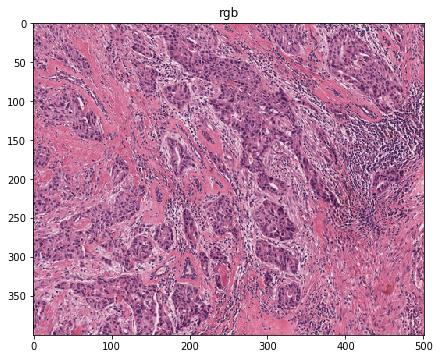

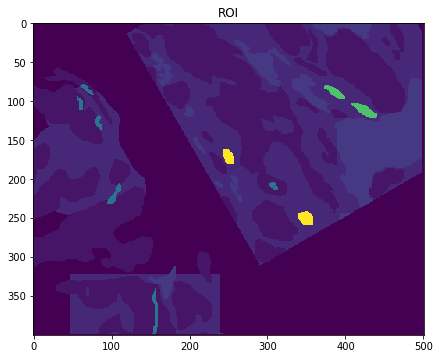

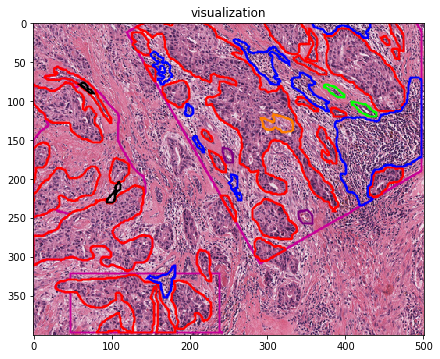

In [11]:
for imstr in ['rgb', 'ROI', 'visualization']:
    plt.imshow(roi_out[imstr])
    plt.title(imstr)
    plt.show()

In [12]:
DataFrame(roi_out['contours']).head()

,group,color,ymin,ymax,xmin,xmax,has_holes,touches_edge-top,touches_edge-left,touches_edge-bottom,touches_edge-right,coords_x,coords_y
0,roi,"rgb(200,0,150)",292.0,398.0,29.0,243.0,0.0,0.0,0.0,0.0,0.0,"214,212,212,211,211,210,210,211,211,212,212,21...","292,294,295,296,299,300,310,311,312,313,314,31..."
1,roi,"rgb(200,0,150)",57.0,319.0,0.0,153.0,0.0,0.0,1.0,0.0,0.0,"31,30,29,27,27,28,29,30,31,31,29,22,21,16,15,1...","57,58,58,60,64,65,64,64,65,66,68,68,69,69,70,7..."
2,roi,"rgb(200,0,150)",0.0,309.0,120.0,498.0,0.0,1.0,0.0,0.0,0.0,"143,142,141,140,139,138,137,135,134,133,132,13...","0,1,1,2,2,3,3,5,5,6,6,7,7,9,9,10,10,11,11,13,1..."
3,mostly_tumor,"rgb(255,0,0)",331.0,393.0,177.0,228.0,0.0,0.0,0.0,0.0,0.0,"185,184,180,180,181,181,182,182,181,181,180,18...","331,332,332,333,334,336,337,342,343,344,345,34..."
4,mostly_tumor,"rgb(255,0,0)",324.0,398.0,29.0,182.0,1.0,0.0,0.0,0.0,0.0,"123,122,120,119,112,111,108,107,94,93,74,73,63...","324,325,325,326,326,327,327,328,328,329,329,33..."


Note that if we were to use the above function call repeatedly for the same slide
(eg to get tiles or multiple regions of interest), this would repeatedly use a 
get request to obtain the annotations from the server, which is inefficient. Instead,
if we know we'll be using this repeatedly for the same slide, we manually get annotations
and scale them down/up to desired resolution, and pass them to `get_image_and_mask_from_slide()`
method. Here's how this could be done. 

In [13]:
# get annotations for slide
slide_annotations = gc.get('/annotation/item/' + SAMPLE_SLIDE_ID)

# scale up/down annotations by a factor
sf, _ = get_scale_factor_and_appendStr(
    gc=gc, slide_id=SAMPLE_SLIDE_ID, MPP=MPP, MAG=MAG)
slide_annotations = scale_slide_annotations(slide_annotations, sf=sf)

# get bounding box information for all annotations
element_infos = get_bboxes_from_slide_annotations(slide_annotations)

In [14]:
# get specified region -- manually providing scaled annotations
roi_out = get_image_and_mask_from_slide(
    mode='manual_bounds', slide_annotations=slide_annotations,
    element_infos=element_infos, **get_kwargs)

/home/mtageld/Desktop/HistomicsTK/histomicstk/annotations_and_masks/annotation_and_mask_utils.py:668: RuntimeWarning: invalid value encountered in greater
  iou = iou[:, iou[1, :] > iou_thresh].astype(int)


In [15]:
roi_out['bounds']

{'XMIN': 58000, 'XMAX': 63000, 'YMIN': 35000, 'YMAX': 39000}

### 2. min_bounding_box mode

If you don't care about any "special" ROI annotations and would just like to parse everything in the
slide into a 'super' minimum-bounding-box semantic segmentation mask, use the `min_bounding_box` mode as follows.

In [16]:
# get ROI bounding everything
minbbox_out = get_image_and_mask_from_slide(
    mode='min_bounding_box', slide_annotations=slide_annotations,
    element_infos=element_infos, **get_kwargs)

In [17]:
minbbox_out['bounds']

{'XMIN': 56736, 'YMIN': 33493, 'XMAX': 63742, 'YMAX': 39900}

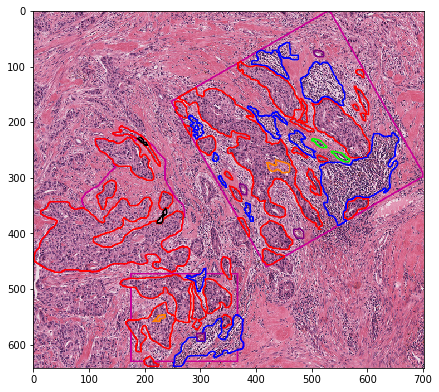

In [18]:
plt.imshow(minbbox_out['visualization'])

### 3. wsi mode
If you just want a miniature version of the slide and all its annotations, usine this mode.

In [19]:
# get entire wsi region
get_kwargs['MPP'] = 5.0  # otherwise it's too large!
wsi_out = get_image_and_mask_from_slide(
    mode='wsi', **get_kwargs)

In [20]:
wsi_out['bounds']

{'XMIN': 0, 'XMAX': 131536, 'YMIN': 0, 'YMAX': 80453}

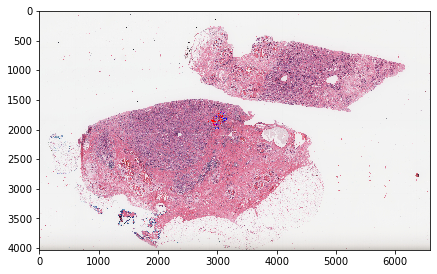

In [21]:
plt.imshow(wsi_out['visualization'])
plt.show()

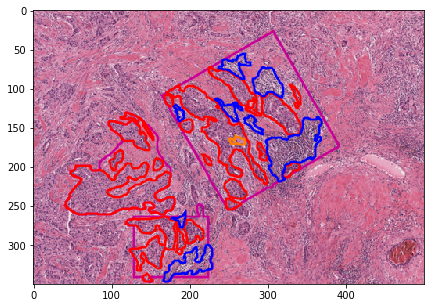

In [22]:
plt.imshow(wsi_out['visualization'][1650:2000, 2800:3300])
plt.show()

## Generate masks for ROIs

This method generates masks for regions defined by ROI annotations (defined groups in the ground truth codes). Annotated structures are mapped to these ROIs, and then each ROI is converted into a single semantic segmentation mask image.

### This is the core method you'll want to use

This utilizes the __polygonal_bounds__ mode of the `get_image_and_mask_from_slide()` method.

In [23]:
print(get_all_rois_from_slide.__doc__)

Parse annotations and saves ground truth masks for ALL ROIs.

    Get all ROIs in a single slide. This is mainly uses
    get_image_and_mask_from_slide(), which should be referred to
    for implementation details.

    Parameters
    -----------
    gc : object
        girder client object to make requests, for example:
        gc = girder_client.GirderClient(apiUrl = APIURL)
        gc.authenticate(interactive=True)

    slide_id : str
        girder id for item (slide)

    GTCodes_dict : dict
        the ground truth codes and information dict.
        This is a dict that is indexed by the annotation group name and
        each entry is in turn a dict with the following keys:
        - group: group name of annotation (string), eg. mostly_tumor
        - overlay_order: int, how early to place the annotation in the
        mask. Larger values means this annotation group is overlayed
        last and overwrites whatever overlaps it.
        - GT_code: int, desired ground truth code (i

In [24]:
detailed_kwargs = {
    'MPP': MPP,
    'MAG': None,
    'get_roi_mask_kwargs': get_roi_mask_kwargs,
    'get_contours_kwargs': get_contours_kwargs,
    'get_rgb': True,
    'get_contours': True,
    'get_visualization': True,
}

The parameter ```get_roi_mask_kwargs``` (which is one of the keys of the parameter ```get_image_and_mask_from_slide_kwargs```) is a dictionary of ```kwargs``` that is eventually passed on to ```get_roi_mask()```. Watch out for the following parameters:

- ```crop_to_roi``` - flag of whether to crop polygons to roi (prevent 'overflow' beyond roi edge)

- ```use_shapely``` - flag of whether to precisely determine whether an element
    belongs to an ROI using shapely polygons. Ever-so-slightly slower. If
    set to False, overlapping bounding box is used as a cheap but
    less precise indicator of inclusion.

In [25]:
savenames = get_all_rois_from_slide(
    gc=gc, slide_id=SAMPLE_SLIDE_ID, GTCodes_dict=GTCodes.T.to_dict(),
    save_directories=SAVEPATHS,
    get_image_and_mask_from_slide_kwargs=detailed_kwargs,
    slide_name='TCGA-A2-A0YE', verbose=False)

In [26]:
savenames[0]

{'ROI': '/tmp/tmpf7ch4pl6/masks/TCGA-A2-A0YE_left-59201_top-33493_bottom-38093_right-63742.png',
 'rgb': '/tmp/tmpf7ch4pl6/rgbs/TCGA-A2-A0YE_left-59201_top-33493_bottom-38093_right-63742.png',
 'visualization': '/tmp/tmpf7ch4pl6/vis/TCGA-A2-A0YE_left-59201_top-33493_bottom-38093_right-63742.png',
 'contours': '/tmp/tmpf7ch4pl6/contours/TCGA-A2-A0YE_left-59201_top-33493_bottom-38093_right-63742.csv'}

### Let's visualize the ROIs created

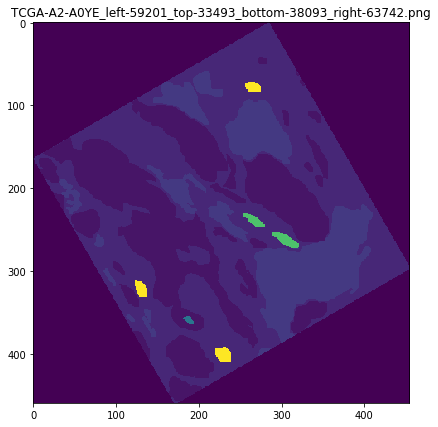

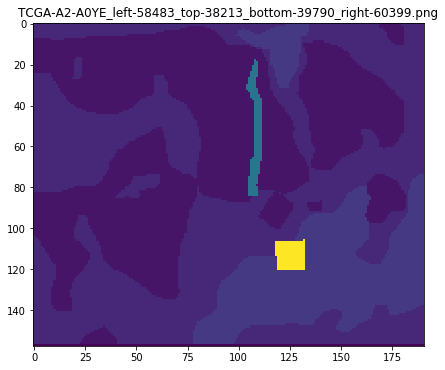

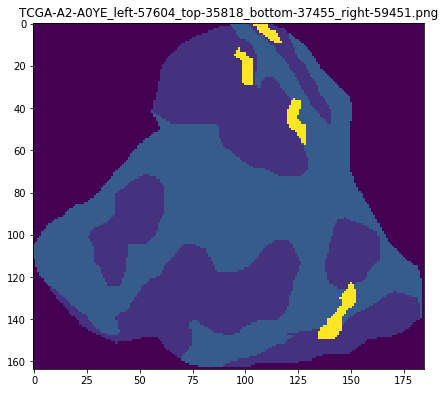

In [27]:
for savename in savenames:
    vis = imread(savename["ROI"])
    plt.imshow(vis)
    plt.title(os.path.basename(savename["ROI"]))
    plt.show()